In [21]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchmetrics import MeanSquaredError
import matplotlib.pyplot as plt

In [2]:
from google.colab import files

uploaded = files.upload()

Saving weather.csv to weather.csv


In [15]:
class WeatherDataset(Dataset):
    def __init__(self, df_path, sequence_length=3, target_col='Maximum temperature (Degree C)',
                 feature_cols=['Rainfall amount (millimetres)', 'Maximum temperature (Degree C)']):
        df = pd.read_csv(df_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values('Date', inplace=True)

        self.features = df[feature_cols].values
        self.target = df[target_col].values

        self.scaler_features = MinMaxScaler()
        self.scaler_target = MinMaxScaler()

        self.features_norm = self.scaler_features.fit_transform(self.features)
        self.target_norm = self.scaler_target.fit_transform(self.target.reshape(-1, 1))

        self.X, self.y = self.create_sequences(
            self.features_norm,
            self.target_norm,
            sequence_length
        )

        self.X = torch.FloatTensor(self.X)
        self.y = torch.FloatTensor(self.y)

    def create_sequences(self, data, target, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(target[i+seq_length])
        return np.array(X), np.array(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def inverse_transform_target(self, y):
        return self.scaler_target.inverse_transform(y.cpu().numpy())

    def get_feature_scaler(self):
        return self.scaler_features

    def get_target_scaler(self):
        return self.scaler_target

In [16]:
dataset = WeatherDataset("weather.csv", sequence_length=2)

train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - (train_size + val_size)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [30]:
class TemperatureBRNN(nn.Module):
    def __init__(self, input_size, num_layers=1):
        super(TemperatureBRNN, self).__init__()
        self.rnn = nn.RNN(input_size, 32, 1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * 32, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemperatureBRNN(input_size=dataset.features_norm.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



Epoch 1/50: 100%|██████████| 37/37 [00:00<00:00, 65.91it/s]


Epoch 1, Train Loss: 0.0259, Train RMSE: 0.1611, Val Loss: 0.0170, Val RMSE: 0.1282
✔ Model improved. Saved to brnn_regression.pth


Epoch 2/50: 100%|██████████| 37/37 [00:00<00:00, 64.46it/s]


Epoch 2, Train Loss: 0.0164, Train RMSE: 0.1281, Val Loss: 0.0163, Val RMSE: 0.1260
✔ Model improved. Saved to brnn_regression.pth


Epoch 3/50: 100%|██████████| 37/37 [00:00<00:00, 64.20it/s]


Epoch 3, Train Loss: 0.0161, Train RMSE: 0.1271, Val Loss: 0.0168, Val RMSE: 0.1278


Epoch 4/50: 100%|██████████| 37/37 [00:00<00:00, 64.27it/s]


Epoch 4, Train Loss: 0.0160, Train RMSE: 0.1269, Val Loss: 0.0181, Val RMSE: 0.1321


Epoch 5/50: 100%|██████████| 37/37 [00:00<00:00, 66.47it/s]


Epoch 5, Train Loss: 0.0166, Train RMSE: 0.1286, Val Loss: 0.0169, Val RMSE: 0.1285


Epoch 6/50: 100%|██████████| 37/37 [00:00<00:00, 64.92it/s]


Epoch 6, Train Loss: 0.0163, Train RMSE: 0.1278, Val Loss: 0.0168, Val RMSE: 0.1276


Epoch 7/50: 100%|██████████| 37/37 [00:00<00:00, 64.93it/s]


Epoch 7, Train Loss: 0.0162, Train RMSE: 0.1271, Val Loss: 0.0167, Val RMSE: 0.1271


Epoch 8/50: 100%|██████████| 37/37 [00:00<00:00, 65.69it/s]


Epoch 8, Train Loss: 0.0160, Train RMSE: 0.1265, Val Loss: 0.0172, Val RMSE: 0.1290


Epoch 9/50: 100%|██████████| 37/37 [00:00<00:00, 40.29it/s]


Epoch 9, Train Loss: 0.0159, Train RMSE: 0.1263, Val Loss: 0.0177, Val RMSE: 0.1307


Epoch 10/50: 100%|██████████| 37/37 [00:00<00:00, 43.06it/s]


Epoch 10, Train Loss: 0.0160, Train RMSE: 0.1266, Val Loss: 0.0181, Val RMSE: 0.1323


Epoch 11/50: 100%|██████████| 37/37 [00:00<00:00, 68.82it/s]


Epoch 11, Train Loss: 0.0165, Train RMSE: 0.1283, Val Loss: 0.0161, Val RMSE: 0.1250
✔ Model improved. Saved to brnn_regression.pth


Epoch 12/50: 100%|██████████| 37/37 [00:00<00:00, 67.99it/s]


Epoch 12, Train Loss: 0.0163, Train RMSE: 0.1275, Val Loss: 0.0161, Val RMSE: 0.1248


Epoch 13/50: 100%|██████████| 37/37 [00:00<00:00, 66.63it/s]


Epoch 13, Train Loss: 0.0159, Train RMSE: 0.1264, Val Loss: 0.0162, Val RMSE: 0.1250


Epoch 14/50: 100%|██████████| 37/37 [00:00<00:00, 64.53it/s]


Epoch 14, Train Loss: 0.0160, Train RMSE: 0.1266, Val Loss: 0.0160, Val RMSE: 0.1245
✔ Model improved. Saved to brnn_regression.pth


Epoch 15/50: 100%|██████████| 37/37 [00:00<00:00, 65.64it/s]


Epoch 15, Train Loss: 0.0163, Train RMSE: 0.1277, Val Loss: 0.0180, Val RMSE: 0.1322


Epoch 16/50: 100%|██████████| 37/37 [00:00<00:00, 65.35it/s]


Epoch 16, Train Loss: 0.0164, Train RMSE: 0.1279, Val Loss: 0.0163, Val RMSE: 0.1257


Epoch 17/50: 100%|██████████| 37/37 [00:00<00:00, 64.68it/s]


Epoch 17, Train Loss: 0.0159, Train RMSE: 0.1262, Val Loss: 0.0170, Val RMSE: 0.1283


Epoch 18/50: 100%|██████████| 37/37 [00:00<00:00, 64.56it/s]


Epoch 18, Train Loss: 0.0166, Train RMSE: 0.1288, Val Loss: 0.0163, Val RMSE: 0.1260


Epoch 19/50: 100%|██████████| 37/37 [00:00<00:00, 64.42it/s]


Epoch 19, Train Loss: 0.0163, Train RMSE: 0.1276, Val Loss: 0.0160, Val RMSE: 0.1243
✔ Model improved. Saved to brnn_regression.pth


Epoch 20/50: 100%|██████████| 37/37 [00:00<00:00, 65.54it/s]


Epoch 20, Train Loss: 0.0168, Train RMSE: 0.1295, Val Loss: 0.0169, Val RMSE: 0.1284


Epoch 21/50: 100%|██████████| 37/37 [00:00<00:00, 51.98it/s]


Epoch 21, Train Loss: 0.0162, Train RMSE: 0.1276, Val Loss: 0.0171, Val RMSE: 0.1286


Epoch 22/50: 100%|██████████| 37/37 [00:00<00:00, 42.38it/s]


Epoch 22, Train Loss: 0.0160, Train RMSE: 0.1268, Val Loss: 0.0163, Val RMSE: 0.1263


Epoch 23/50: 100%|██████████| 37/37 [00:00<00:00, 64.46it/s]


Epoch 23, Train Loss: 0.0159, Train RMSE: 0.1262, Val Loss: 0.0164, Val RMSE: 0.1265


Epoch 24/50: 100%|██████████| 37/37 [00:00<00:00, 64.55it/s]


Epoch 24, Train Loss: 0.0162, Train RMSE: 0.1271, Val Loss: 0.0164, Val RMSE: 0.1261


Epoch 25/50: 100%|██████████| 37/37 [00:00<00:00, 65.38it/s]


Epoch 25, Train Loss: 0.0160, Train RMSE: 0.1266, Val Loss: 0.0168, Val RMSE: 0.1276


Epoch 26/50: 100%|██████████| 37/37 [00:00<00:00, 64.97it/s]


Epoch 26, Train Loss: 0.0160, Train RMSE: 0.1264, Val Loss: 0.0160, Val RMSE: 0.1247


Epoch 27/50: 100%|██████████| 37/37 [00:00<00:00, 67.31it/s]


Epoch 27, Train Loss: 0.0161, Train RMSE: 0.1272, Val Loss: 0.0160, Val RMSE: 0.1244


Epoch 28/50: 100%|██████████| 37/37 [00:00<00:00, 55.70it/s]


Epoch 28, Train Loss: 0.0163, Train RMSE: 0.1276, Val Loss: 0.0159, Val RMSE: 0.1246
✔ Model improved. Saved to brnn_regression.pth


Epoch 29/50: 100%|██████████| 37/37 [00:00<00:00, 64.88it/s]


Epoch 29, Train Loss: 0.0159, Train RMSE: 0.1259, Val Loss: 0.0165, Val RMSE: 0.1266


Epoch 30/50: 100%|██████████| 37/37 [00:00<00:00, 66.04it/s]


Epoch 30, Train Loss: 0.0158, Train RMSE: 0.1256, Val Loss: 0.0169, Val RMSE: 0.1279


Epoch 31/50: 100%|██████████| 37/37 [00:00<00:00, 65.00it/s]


Epoch 31, Train Loss: 0.0158, Train RMSE: 0.1258, Val Loss: 0.0158, Val RMSE: 0.1244
✔ Model improved. Saved to brnn_regression.pth


Epoch 32/50: 100%|██████████| 37/37 [00:00<00:00, 68.87it/s]


Epoch 32, Train Loss: 0.0155, Train RMSE: 0.1245, Val Loss: 0.0160, Val RMSE: 0.1249


Epoch 33/50: 100%|██████████| 37/37 [00:00<00:00, 56.55it/s]


Epoch 33, Train Loss: 0.0156, Train RMSE: 0.1247, Val Loss: 0.0154, Val RMSE: 0.1231
✔ Model improved. Saved to brnn_regression.pth


Epoch 34/50: 100%|██████████| 37/37 [00:00<00:00, 42.33it/s]


Epoch 34, Train Loss: 0.0159, Train RMSE: 0.1257, Val Loss: 0.0177, Val RMSE: 0.1316


Epoch 35/50: 100%|██████████| 37/37 [00:00<00:00, 51.01it/s]


Epoch 35, Train Loss: 0.0153, Train RMSE: 0.1236, Val Loss: 0.0154, Val RMSE: 0.1236
✔ Model improved. Saved to brnn_regression.pth


Epoch 36/50: 100%|██████████| 37/37 [00:00<00:00, 66.18it/s]


Epoch 36, Train Loss: 0.0157, Train RMSE: 0.1251, Val Loss: 0.0169, Val RMSE: 0.1280


Epoch 37/50: 100%|██████████| 37/37 [00:00<00:00, 64.88it/s]


Epoch 37, Train Loss: 0.0154, Train RMSE: 0.1241, Val Loss: 0.0155, Val RMSE: 0.1235


Epoch 38/50: 100%|██████████| 37/37 [00:00<00:00, 62.97it/s]


Epoch 38, Train Loss: 0.0153, Train RMSE: 0.1237, Val Loss: 0.0153, Val RMSE: 0.1235
✔ Model improved. Saved to brnn_regression.pth


Epoch 39/50: 100%|██████████| 37/37 [00:00<00:00, 64.80it/s]


Epoch 39, Train Loss: 0.0155, Train RMSE: 0.1244, Val Loss: 0.0154, Val RMSE: 0.1234


Epoch 40/50: 100%|██████████| 37/37 [00:00<00:00, 65.01it/s]


Epoch 40, Train Loss: 0.0154, Train RMSE: 0.1243, Val Loss: 0.0152, Val RMSE: 0.1230
✔ Model improved. Saved to brnn_regression.pth


Epoch 41/50: 100%|██████████| 37/37 [00:00<00:00, 65.25it/s]


Epoch 41, Train Loss: 0.0154, Train RMSE: 0.1240, Val Loss: 0.0153, Val RMSE: 0.1224


Epoch 42/50: 100%|██████████| 37/37 [00:00<00:00, 63.31it/s]


Epoch 42, Train Loss: 0.0152, Train RMSE: 0.1232, Val Loss: 0.0166, Val RMSE: 0.1277


Epoch 43/50: 100%|██████████| 37/37 [00:00<00:00, 63.97it/s]


Epoch 43, Train Loss: 0.0155, Train RMSE: 0.1244, Val Loss: 0.0152, Val RMSE: 0.1228
✔ Model improved. Saved to brnn_regression.pth


Epoch 44/50: 100%|██████████| 37/37 [00:00<00:00, 67.64it/s]


Epoch 44, Train Loss: 0.0152, Train RMSE: 0.1233, Val Loss: 0.0156, Val RMSE: 0.1247


Epoch 45/50: 100%|██████████| 37/37 [00:00<00:00, 65.94it/s]


Epoch 45, Train Loss: 0.0152, Train RMSE: 0.1230, Val Loss: 0.0152, Val RMSE: 0.1229


Epoch 46/50: 100%|██████████| 37/37 [00:00<00:00, 40.09it/s]


Epoch 46, Train Loss: 0.0150, Train RMSE: 0.1226, Val Loss: 0.0154, Val RMSE: 0.1235


Epoch 47/50: 100%|██████████| 37/37 [00:00<00:00, 48.43it/s]


Epoch 47, Train Loss: 0.0149, Train RMSE: 0.1222, Val Loss: 0.0156, Val RMSE: 0.1246


Epoch 48/50: 100%|██████████| 37/37 [00:00<00:00, 66.49it/s]


Epoch 48, Train Loss: 0.0153, Train RMSE: 0.1239, Val Loss: 0.0151, Val RMSE: 0.1222
✔ Model improved. Saved to brnn_regression.pth


Epoch 49/50: 100%|██████████| 37/37 [00:00<00:00, 65.23it/s]


Epoch 49, Train Loss: 0.0151, Train RMSE: 0.1228, Val Loss: 0.0156, Val RMSE: 0.1244


Epoch 50/50: 100%|██████████| 37/37 [00:00<00:00, 64.68it/s]


Epoch 50, Train Loss: 0.0150, Train RMSE: 0.1224, Val Loss: 0.0154, Val RMSE: 0.1241
✅ Best model loaded from brnn_regression.pth
Test Loss: 0.0137, Test RMSE: 0.1187


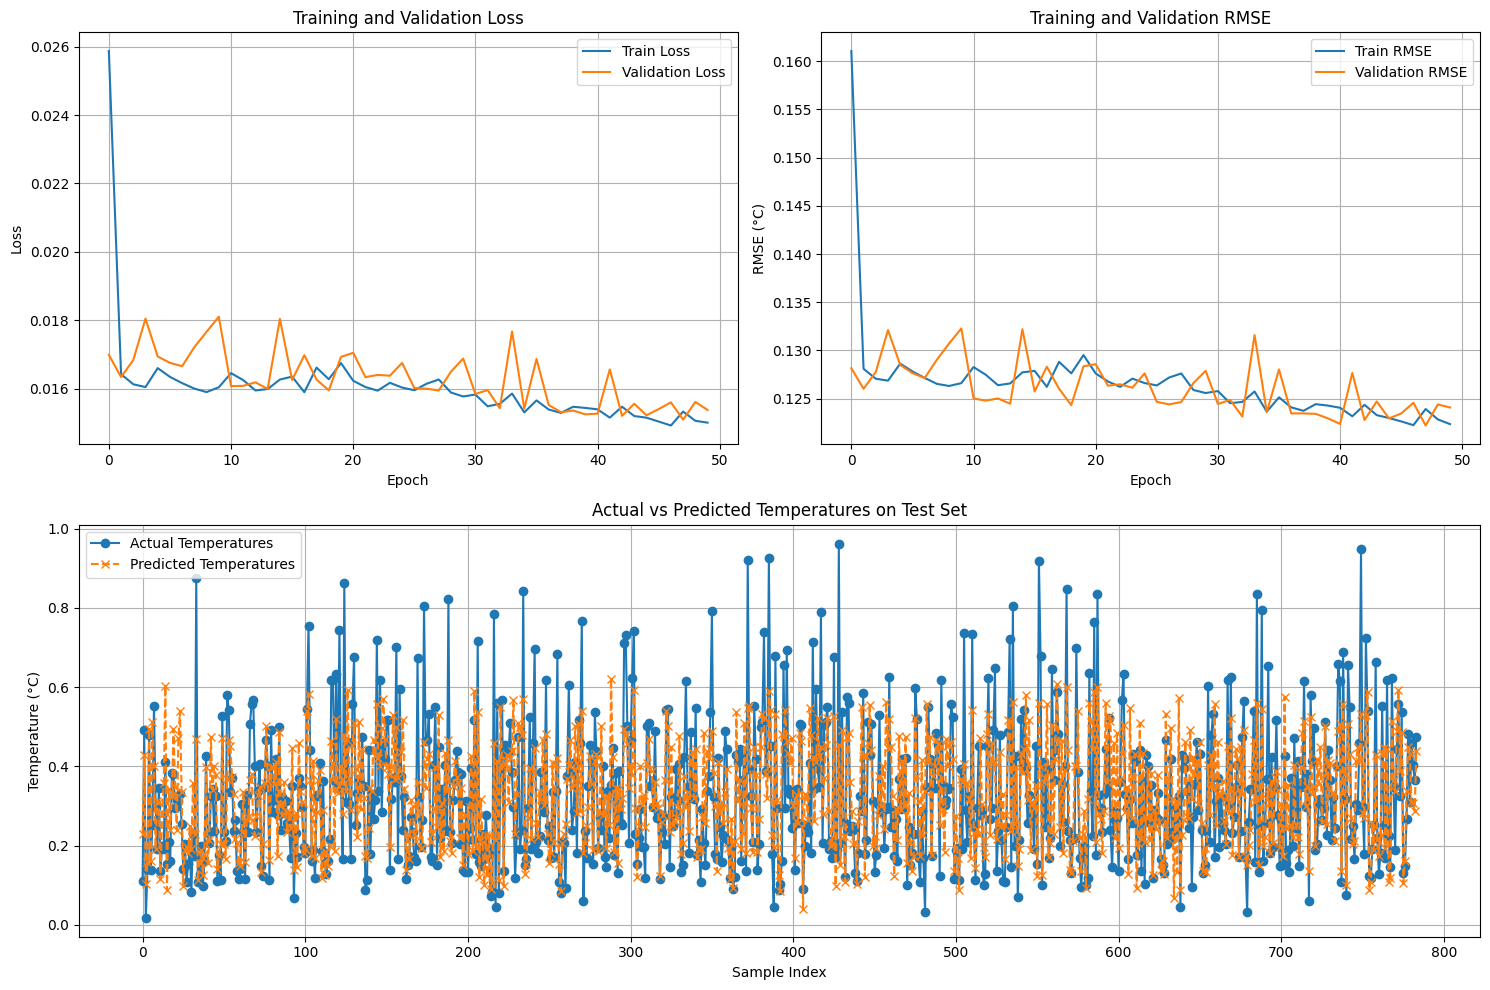

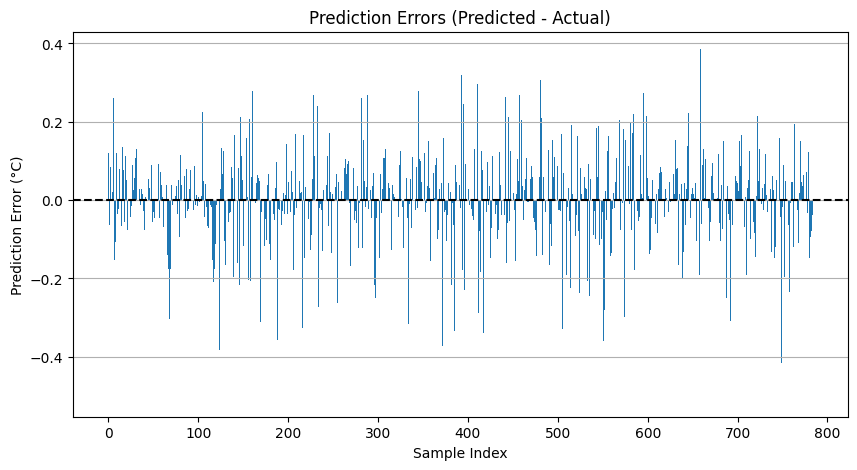

In [32]:
train_loss_history = []
val_loss_history = []
train_rmse_history = []
val_rmse_history = []
test_predictions = []
test_actuals = []

epochs = 50
patience = 10
best_val_loss = float("inf")
patience_counter = 0
model_path = "brnn_regression.pth"

rmse = MeanSquaredError(squared=False).to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    rmse.reset()

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        rmse.update(outputs, y_batch)

    train_loss = running_loss / len(train_loader)
    train_rmse = rmse.compute().item()
    train_loss_history.append(train_loss)
    train_rmse_history.append(train_rmse)

    model.eval()
    val_loss = 0.0
    rmse.reset()

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            rmse.update(outputs, y_batch)

    val_loss /= len(val_loader)
    val_rmse = rmse.compute().item()
    val_loss_history.append(val_loss)
    val_rmse_history.append(val_rmse)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_path)
        print(f"✔ Model improved. Saved to {model_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

model.load_state_dict(torch.load(model_path))
model.to(device)
print(f"✅ Best model loaded from {model_path}")

model.eval()
test_loss = 0.0
rmse.reset()

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        rmse.update(outputs, y_batch)

        test_predictions.extend(outputs.cpu().numpy().flatten())
        test_actuals.extend(y_batch.cpu().numpy().flatten())

test_loss /= len(test_loader)
test_rmse = rmse.compute().item()
print(f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE (°C)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, (3,4))
plt.plot(test_actuals, 'o-', label='Actual Temperatures')
plt.plot(test_predictions, 'x--', label='Predicted Temperatures')
plt.xlabel('Sample Index')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperatures on Test Set')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
errors = np.array(test_predictions) - np.array(test_actuals)
plt.bar(range(len(errors)), errors)
plt.xlabel('Sample Index')
plt.ylabel('Prediction Error (°C)')
plt.title('Prediction Errors (Predicted - Actual)')
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(True, axis='y')
plt.show()